# ***PROYECTO ESPECIALIZACIÓN EN CIENCIA DE DATOS E IA***

*Presentadopor: Jonathan, Jhon y Felipe***

# *1.Presentación de los datos*

Importamos librerias necesarias

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# *2.Carga y exploración del conjunto de datos*

In [ ]:
# Cargar el archivo
archivo = "Proyecto1_UdeM/BD_Pendientes_No_Revisadas.xlsx"
df = pd.read_excel(archivo)

# Mostrar las primeras filas
df.head()

,RESPUESTA,SERVICIO,OBSERVACION_ACTUAL,CONSUMO_CRITICADO,FUNCION_ANALISIS,CALIFICACION
0,1,101-AGUA POTABLE,31-MEDIDOR CAMBIADO,81.58,PEOBTECOPP - Obtener Consumo Promedio Individu...,2-ENVÍA A CRÍTICA
1,1,101-AGUA POTABLE,39-VER ALFANUMERICA,408.00,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%)
2,1,101-AGUA POTABLE,35-NO HAY JUSTIFICACION,-3.00,PECALCCOLA - Calcular Consumo por Lectura Ante...,5036-BAJO ACUEDUCTO (<-65%)
3,1,101-AGUA POTABLE,35-NO HAY JUSTIFICACION,-377.00,PECALCCOLA - Calcular Consumo por Lectura Ante...,5036-BAJO ACUEDUCTO (<-65%)
4,0,101-AGUA POTABLE,0-SIN CAUSA NI OBSERVACIÓN,11.00,PECALCCOLA - Calcular Consumo por Lectura Ante...,2-ENVÍA A CRÍTICA


# *3.Tratamiento de datos e imputación*

In [ ]:
df['CODIGO_SERVICIO'] = df['SERVICIO'].str.split('-', n=1).str[0]
df.drop(columns=['SERVICIO'], inplace=True)

df['CODIGO_OBSERVACION'] = df['OBSERVACION_ACTUAL'].str.split('-', n=1).str[0]
df.drop(columns=['OBSERVACION_ACTUAL'], inplace=True)

df['CODIGO_CALIFICACION'] = df['CALIFICACION'].str.split('-', n=1).str[0]
df.drop(columns=['CALIFICACION'], inplace=True)

,RESPUESTA,CONSUMO_CRITICADO,FUNCION_ANALISIS,CODIGO_SERVICIO,CODIGO_OBSERVACION,CODIGO_CALIFICACION
0,1,81.58,PEOBTECOPP - Obtener Consumo Promedio Individu...,101,31,2
1,1,408.00,CALCCOLE - Calcular Consumo por Lecturas,101,39,5080
2,1,-3.00,PECALCCOLA - Calcular Consumo por Lectura Ante...,101,35,5036
3,1,-377.00,PECALCCOLA - Calcular Consumo por Lectura Ante...,101,35,5036
4,0,11.00,PECALCCOLA - Calcular Consumo por Lectura Ante...,101,0,2
...,...,...,...,...,...,...
96340,1,0.00,CALCCOPR - Calcular Consumo Penalizado de Ener...,701,0,2
96341,1,186.50,CALCCOPR - Calcular Consumo Penalizado de Ener...,701,0,2
96342,1,0.00,CALCCOPR - Calcular Consumo Penalizado de Ener...,701,23,2
96343,1,21.50,CALCCOPR - Calcular Consumo Penalizado de Ener...,701,0,2


In [ ]:


# Copiar el DataFrame para trabajar sobre una nueva variable
df_modelo = df.copy()

# Columnas categóricas a codificar
columnas_categoricas = ['FUNCION_ANALISIS']

# Inicializar codificadores
encoders = {}
for col in columnas_categoricas:
    le = LabelEncoder()
    df_modelo[col] = le.fit_transform(df_modelo[col].astype(str))
    encoders[col] = le  # Guardamos el encoder para posibles decodificaciones posteriores

# Verificar resultado
df_modelo.head()

,RESPUESTA,CONSUMO_CRITICADO,FUNCION_ANALISIS,CODIGO_SERVICIO,CODIGO_OBSERVACION,CODIGO_CALIFICACION
0,1,81.58,10,101,31,2
1,1,408.00,3,101,39,5080
2,1,-3.00,7,101,35,5036
3,1,-377.00,7,101,35,5036
4,0,11.00,7,101,0,2


# *4.Medidas y gráficas descriptivas multivariadas*

In [17]:
df_modelo.corr()

,RESPUESTA,CONSUMO_CRITICADO,FUNCION_ANALISIS,CODIGO_SERVICIO,CODIGO_OBSERVACION,CODIGO_CALIFICACION
RESPUESTA,1.000000,0.004604,-0.004977,0.025184,0.213283,0.076109
CONSUMO_CRITICADO,0.004604,1.000000,0.000448,-0.000889,0.001564,-0.006869
FUNCION_ANALISIS,-0.004977,0.000448,1.000000,-0.042977,-0.264632,-0.487162
CODIGO_SERVICIO,0.025184,-0.000889,-0.042977,1.000000,-0.131297,0.053807
CODIGO_OBSERVACION,0.213283,0.001564,-0.264632,-0.131297,1.000000,0.382600
CODIGO_CALIFICACION,0.076109,-0.006869,-0.487162,0.053807,0.382600,1.000000


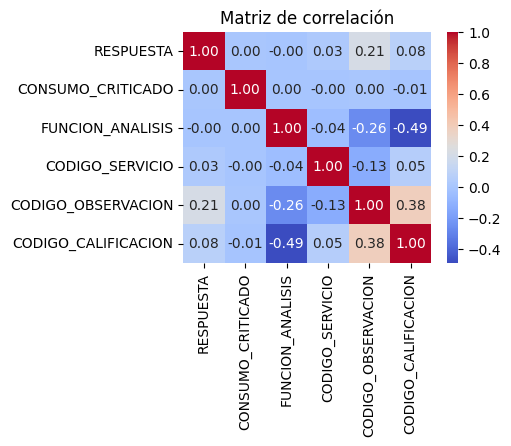

In [18]:
# Verificamos correlación entre numéricas
plt.figure(figsize=(4, 3))
sns.heatmap(df_modelo.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

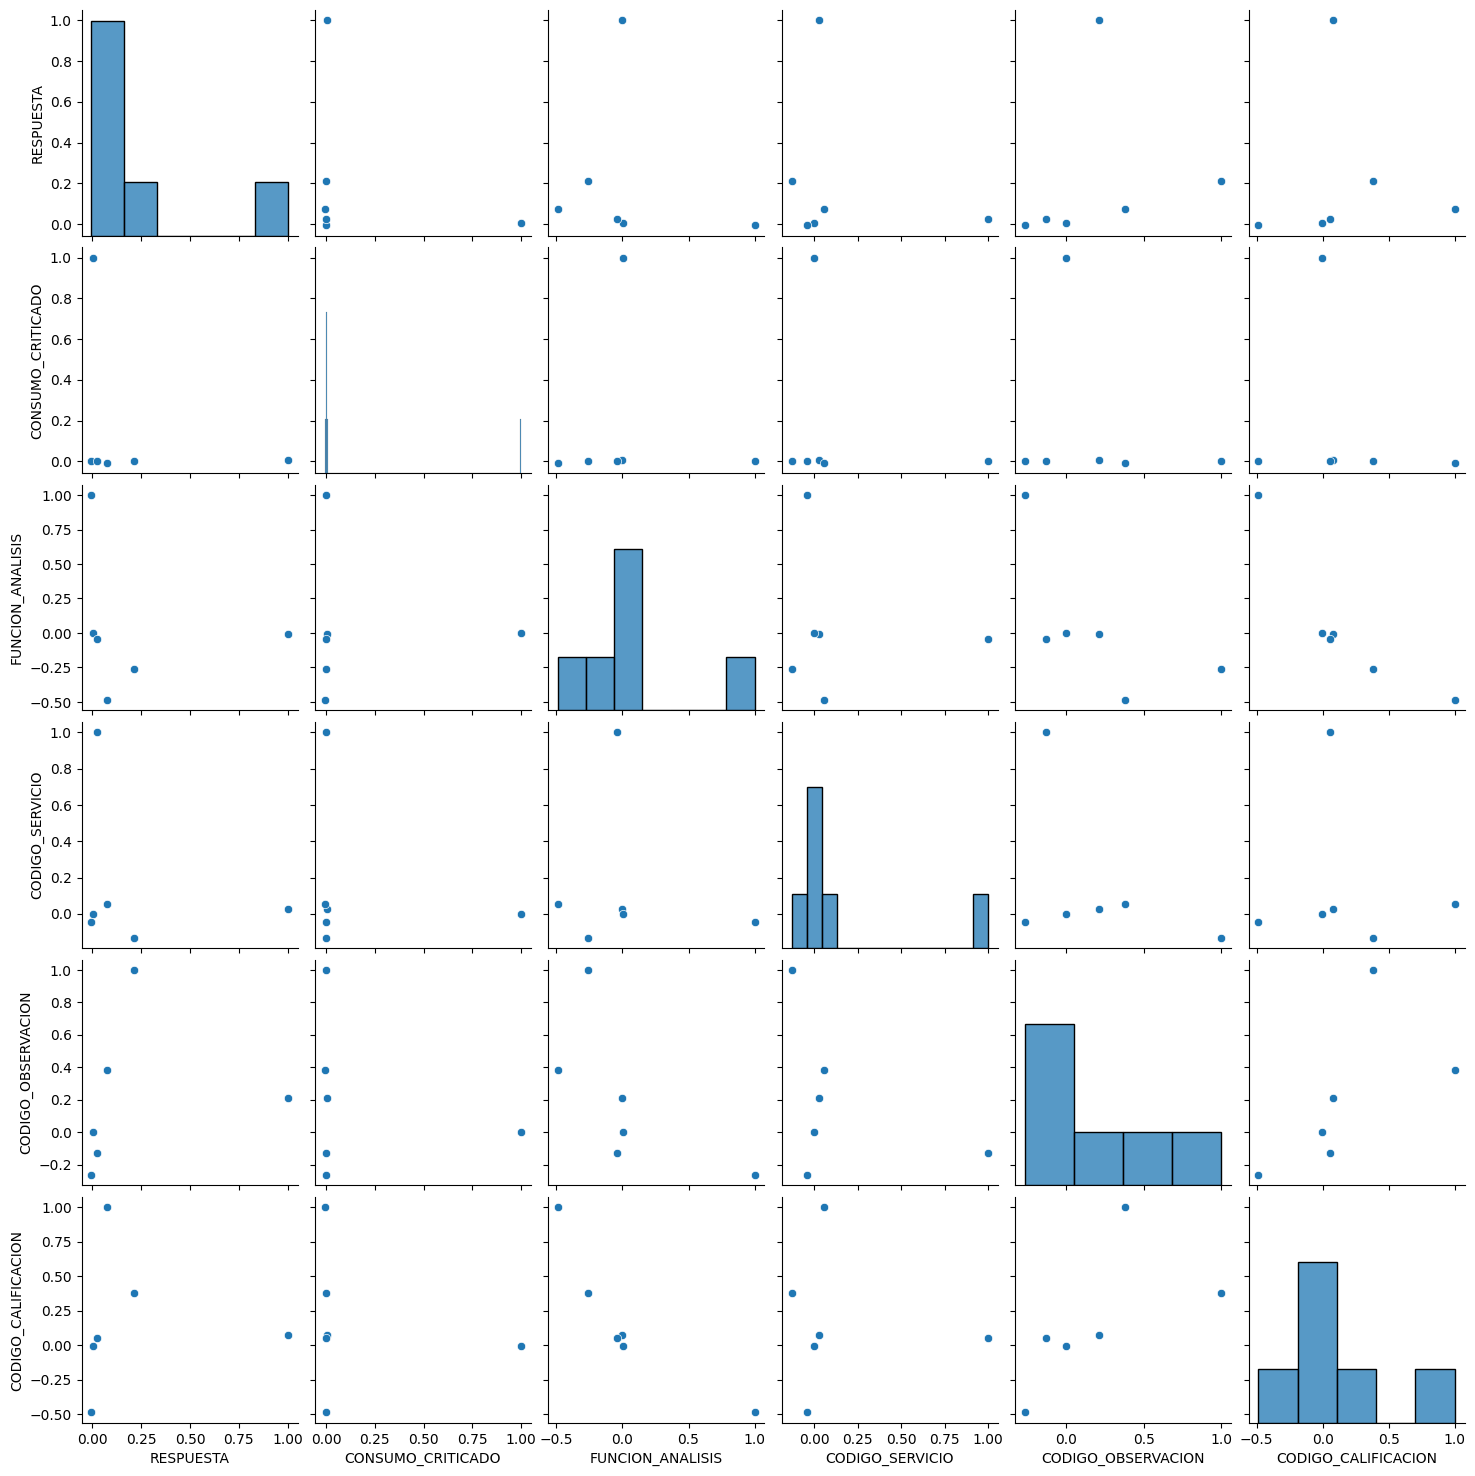

In [19]:
sns.pairplot(df_modelo.corr())